In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

In [22]:
def generate_adj(alphas,thetas):
    num_nodes = len(alphas)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            norm_diff = np.linalg.norm(thetas[i] - thetas[j])**2
            m_ij = alphas[i] + alphas[j] - norm_diff
            adjacency_matrix[i][j] = np.random.poisson(lam = np.exp(m_ij))
            adjacency_matrix[j][i] = adjacency_matrix[i][j]
    return adjacency_matrix

def distance_matrix(point_theta):
    n = point_theta.shape[0]
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(point_theta[i] - point_theta[j])**2
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

def generate_M_matrix(alphas, thetas):
    num_nodes = len(alphas)
    M = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
            M[i][j] = alphas[i] + alphas[j] - norm_squared
            M[j][i] = M[i][j]
    return M

def f(A, alphas, thetas):
    M = generate_M_matrix(alphas, thetas)
    num_nodes = A.shape[0]
    result = 0
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                result += -np.exp(M[i][j])-np.log(factorial(A[i][j]))+A[i][j]*M[i][j]
    return result

def Projection(X,C):
    return X if np.linalg.norm(X) < C else C*X/np.linalg.norm(X)

def gradient_theta(A, alphas, thetas):
    num_nodes = len(alphas)
    gradient = np.zeros_like(thetas)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                term = alphas[i] + alphas[j] - norm_squared
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)

                gradient[i] += -2 * A[i][j] * (thetas[i] - thetas[j]) + \
                                2 * (thetas[i] - thetas[j]) * np.exp(term)*term
    return gradient

def gradient_alpha(A, alphas, thetas):
    num_nodes = len(alphas)
    gradient = np.zeros_like(alphas)
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                term = alphas[i] + alphas[j] - norm_squared
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)
                gradient[i] += A[i][j] - term*np.exp(term)
    
    return gradient

In [23]:
def main(num_samples, k, C, learning_rate):
    # Generate alpha
    true_alpha = np.random.rand(num_samples)
    # true_alpha = np.random.uniform(-1, 1, num_samples)

    # Generate theta method
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # true_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    # Generate adjacency matrix
    adjacency_matrix = generate_adj(true_alpha, true_theta)

    # Generate distance matrix
    distance_matrix_ = distance_matrix(true_theta)

    # pred_alpha = true_alpha
    # pred_theta = true_theta
    
    pred_alpha = np.random.rand(num_samples)
    # pred_alpha = np.random.uniform(-1, 1, num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # pred_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    logli = f(adjacency_matrix, pred_alpha, pred_theta)

    avg_loss_theta = []
    avg_loss_alpha = []
    max_loss_theta = []
    max_loss_alpha = []
    logli_list = []

    # Learning rate adjustment variables
    decay_rate = 0.9  
    min_learning_rate = 0.0001

    flag = True
    iter = 0
    while flag:
        iter += 1
        # update theta
        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta)
        prev_theta = pred_theta
        pred_theta = Projection(pred_theta + learning_rate*grad_y, C)
        diff_distance = distance_matrix_-distance_matrix(pred_theta)
        avg_loss_theta.append(np.linalg.norm(diff_distance, ord='fro')**2/len(pred_theta)**2)
        max_loss_theta.append(np.abs(diff_distance).max())  

        # update alpha
        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, pred_theta)
        prev_alpha = pred_alpha
        pred_alpha = Projection(pred_alpha + learning_rate*grad_x, C)
        diff_alpha = true_alpha-pred_alpha
        avg_loss_alpha.append(np.linalg.norm(diff_alpha)**2/len(pred_alpha))
        max_loss_alpha.append(np.abs(diff_alpha).max())

        prev_logli = logli
        logli = f(adjacency_matrix, pred_alpha, pred_theta)
        logli_list.append(prev_logli)

        if (logli-prev_logli)/np.abs(prev_logli) < 0.0001:
            flag = False

        # Update the learning rate
        learning_rate = max(min_learning_rate, learning_rate * decay_rate)

    return avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list

In [24]:
def main_(num_samples, k, C, learning_rate):
    # Generate alpha
    true_alpha = np.random.rand(num_samples)
    # true_alpha = np.random.uniform(-1, 1, num_samples)

    # Generate theta method
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # true_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    # Generate adjacency matrix
    adjacency_matrix = generate_adj(true_alpha, true_theta)

    # Generate distance matrix
    distance_matrix_ = distance_matrix(true_theta)

    # pred_alpha = true_alpha
    # pred_theta = true_theta
    
    pred_alpha = np.random.rand(num_samples)
    # pred_alpha = np.random.uniform(-1, 1, num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # pred_theta = np.random.uniform(-1, 1, num_samples*k).reshape(num_samples,-1)

    logli = f(adjacency_matrix, pred_alpha, pred_theta)

    avg_loss_theta = []
    avg_loss_alpha = []
    max_loss_theta = []
    max_loss_alpha = []
    logli_list = []
    for i in range(10):
        # update theta
        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta)
        prev_theta = pred_theta
        pred_theta = Projection(pred_theta + learning_rate*grad_y, C)
        diff_distance = distance_matrix_-distance_matrix(pred_theta)
        avg_loss_theta.append(np.linalg.norm(diff_distance, ord='fro')**2/len(pred_theta)**2)
        max_loss_theta.append(np.abs(diff_distance).max())  

        # update alpha
        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, pred_theta)
        prev_alpha = pred_alpha
        pred_alpha = Projection(pred_alpha + learning_rate*grad_x, C)
        diff_alpha = true_alpha-pred_alpha
        avg_loss_alpha.append(np.linalg.norm(diff_alpha)**2/len(pred_alpha))
        max_loss_alpha.append(np.abs(diff_alpha).max())

        prev_logli = logli
        logli = f(adjacency_matrix, pred_alpha, pred_theta)
        logli_list.append(prev_logli)

        # if (logli-prev_logli) < 0.01:
        #     flag = False

    return avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list

In [25]:
# np.random.seed(2)
num_samples = 200
k = 2
C = 10000
learning_rate = 0.00001

avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list = main(num_samples, k, C, learning_rate)

In [26]:
relative_errors = []

for i in range(1, len(logli_list)):
    relative_error = (logli_list[i] - logli_list[i-1])/abs(logli_list[i-1])
    relative_errors.append(relative_error)

print(relative_errors)

[0.006142225378390356, 0.05581256633191004, 0.04488882159242946, 0.035220491555720636, 0.027109474967197116, 0.02061234169139485, 0.015598624926928824, 0.011836436423116305, 0.009066791747763678, 0.0070503920883014225, 0.0055885188100315555, 0.004526812105098246, 0.0037504412250538846, 0.003176336898818379, 0.002745453221384823, 0.002416251458562758, 0.0021596604540349905, 0.0019553649864447933, 0.0017891513239030044, 0.0016510420977296893, 0.0015339990554118486, 0.0014330255008841563, 0.0013445464747172198, 0.001265980615962228, 0.001195443920279663, 0.0011315442208388066, 0.001073238153423823, 0.0010197312577948456, 0.0009704079479427401, 0.0009247822328286385, 0.0008824629018147346, 0.0008431288270691186, 0.0008065113651788694, 0.0007723817551291257, 0.0007405420434568441, 0.0007108185056784513, 0.0006830568395830614, 0.0006571186197285143, 0.000632878651715134, 0.0006102229710233737, 0.0005890473055537706, 0.0005692558727632568, 0.0005507604202761775, 0.0005334794452610418, 0.00051

In [27]:
len(relative_errors)

278

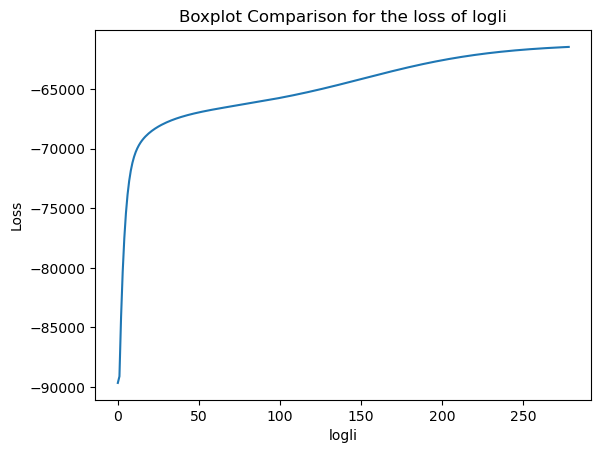

In [28]:
plt.plot(logli_list)
plt.title(fr'Boxplot Comparison for the loss of logli')
plt.xlabel('logli')
plt.ylabel('Loss')
plt.show()

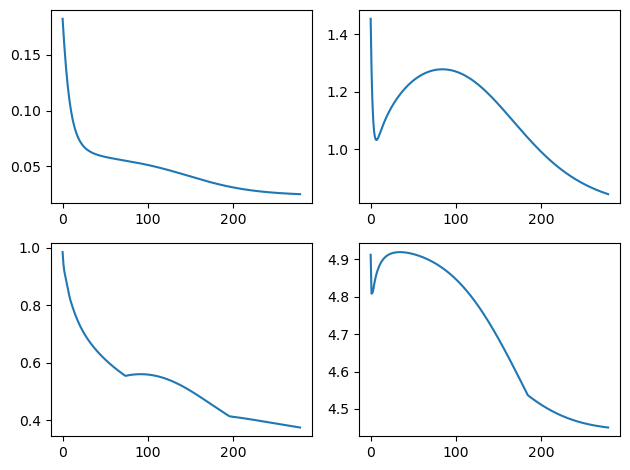

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 定义四个列表的数据
avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta

# 创建一个 2x2 的子图布局
fig, axs = plt.subplots(2, 2)

# 绘制每个子图的线图
axs[0, 0].plot(avg_loss_alpha)
axs[0, 1].plot(avg_loss_theta)
axs[1, 0].plot(max_loss_alpha)
axs[1, 1].plot(max_loss_theta)

# 调整子图的布局和样式
plt.tight_layout()

# 显示图形
plt.show()